<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Use natural language to visualize U.S. Markets from Japan**


## Overview


近年、日本の個人投資家は、非課税投資枠(NISA)の導入により、米国の金融市場や株式が注目しています。ところが、日本に住んでいる間、アメリカ経済を体感するのは難しい。日本に住んでいる間にアメリカ株の投資タイミングを判断する方法はないのでしょうか。

米国市場の強気（牛：Bull）と弱気（熊：Bear）を可視化することができたら、投資判断に使えるのではないかというのが、今回の着眼点です。

2024年9月のFOMCでパウエル議長は言いました。この50ベーシスポイントはFRBは遅れを取らないという決意であると。 だとすると、25ベーシスポイントまではわずかな強気または弱気で50ベーシスポイントを超えると、米国の国債は、とても強気または弱気ということになります。


このノートブックでは、IBMのデータサイエンス専門講座のオプション講座で教材となった、スキルブックを使用します。今私は文章を日本語で記載しています。教材は英語ですが、IBMのワトソンxでLLMにLlama3を使用しています。Llama3は標準で日本語も理解するので、日本語で命令文を記述しても米国のマーケットデータを可視化してくれます。

以降はところどころ日本語になっています。順にPythonを実行してみると、日本語を理解しながらLlamaがマーケットデータを可視化していく様子がよくわかると思います。


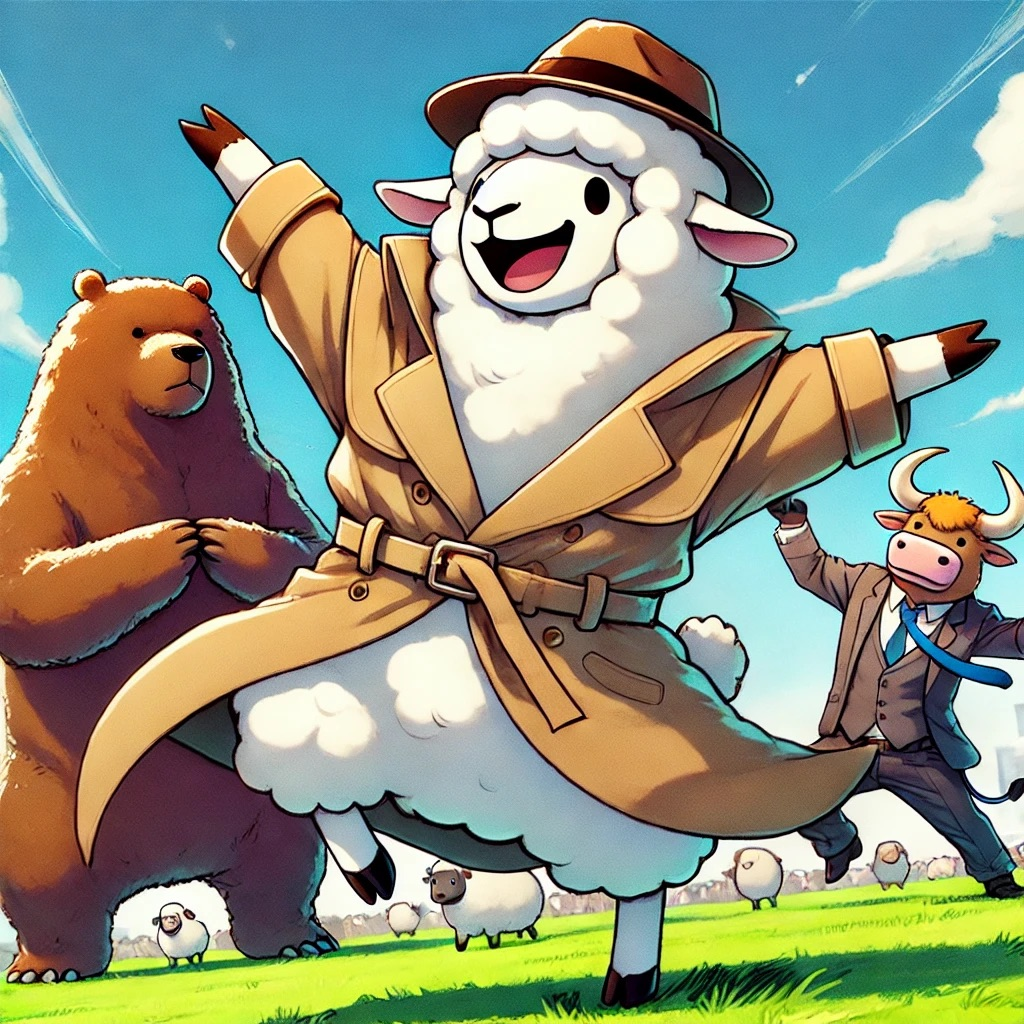

In [1]:
#ChatGPTで生成した、探偵の格好（Watson）をした羊（Llama）が、BullとBearと一緒に踊る画像です。ジャパニーズアニメスタイル（Japanese Anime Style）で生成しています。
from IPython.display import Image
Image(filename='BullBear.jpeg')


## Setup（IBM Skills Networkより）


This project is based on Jupyter Notebook. If you're not familiar with it, here's a quick guide on how to run code within it:

A Jupyter Notebook consists of cells. To execute a code cell, click on the cell that you want to run and click the 'Run' button, as shown in the picture.


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IwbhiH3Wwv-VK-J4rioTAw/run.png" width="50%" alt="indexing"/>


For this lab, we will be using the following libraries:

*   [`ibm-watson-ai`](https://ibm.github.io/watson-machine-learning-sdk/index.html) for using LLMs from IBM's watsonx.ai.
*   [`LangChain`, `langchain-ibm`, `langchain-experimental`](https://www.langchain.com/) for using its agent function to interact with data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.


### Installing required libraries

The following required libraries are __not__ preinstalled in the Skills Network Labs environment. __You must run the following cell__ to install them:

**Note:** We are pinning the version here to specify the version. It's recommended that you do this as well. Even if the library is updated in the future, the installed library could still support this lab work.

This might take approximately 1-2 minutes. 

As we use `%%capture` to capture the installation, you won't see the output process. But after the installation completes, you will see a number beside the cell.


In [2]:
%%capture
!pip install ibm-watsonx-ai=="0.2.6"
!pip install langchain=="0.1.16" 
!pip install langchain-ibm=="0.1.4"
!pip install langchain-experimental=="0.0.57"
!pip install matplotlib=="3.8.4"
!pip install seaborn=="0.13.2"


In [3]:
# We use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

from ibm_watsonx_ai.foundation_models import Model
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watson_machine_learning.foundation_models.extensions.langchain import WatsonxLLM

from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

import matplotlib.pyplot as plt
import pandas as pd

## Data set


普段はYahoo!ファイナンスのCSVダウンロードを使用していました。ところが最近、CSVダウンロード機能が、フリーからゴールド会員に料金変更されてしまいました。

これは大変残念なので、代替としてGoogle Sheetのグーグルファイナンス関数を使います。こちらはシートなので、データを見ながら関数が使えますから、マーケットデータの準備には大変良いツールです。

今回はFRBの動向が気になるので、金利指標として10年TNoteの価格を使います。
予めGoogleシート上で、関数　=@googlefinance("ZNW00","Date","Price","[Start Date]","[Close Date]","Daily")

また前日比で25ベーシスポイントより低く上昇している場合はやや強気（２）、それより上昇している時はとても強気（３）、マイナス２５ベーシスポイントはやや弱気（１）、それよりもマイナスはとても弱気（０）といった具合に、シート上で簡単な階層分けをしています。

これをCSVにダウンロードして、次のプログラムで読み取っています。

In [4]:
#あらかじめgoogle sheet 上でGoogleファイナンス関数を使ってデータ準備をする。今回のティッカーはZNW00でT-Note１０年の継続契約、要は長期債権である。
df = pd.read_csv("ZNW00.csv")


In [5]:
df.tail(20)


,Date,Close,DateGroup,Rate_To_PreviousDay,Bull_Bear
1238,2024/08/21 23:58:00,113.89,202408,0.002906,3
1239,2024/08/22 23:58:00,113.30,202408,-0.005180,0
1240,2024/08/23 23:58:00,113.70,202408,0.003530,3
1241,2024/08/26 23:58:00,113.59,202408,-0.000967,1
1242,2024/08/27 23:58:00,113.52,202408,-0.000616,1
1243,2024/08/28 23:58:00,114.08,202408,0.004933,3
1244,2024/08/29 23:58:00,113.88,202408,-0.001753,1
1245,2024/08/30 23:58:00,113.56,202408,-0.002810,0
1246,2024/09/03 23:58:00,114.00,202409,0.003875,3
1247,2024/09/04 23:58:00,114.56,202409,0.004912,3


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 1258 non-null   object 
 1   Close                1258 non-null   float64
 2   DateGroup            1258 non-null   int64  
 3   Rate_To_PreviousDay  1258 non-null   float64
 4   Bull_Bear            1258 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 49.3+ KB


In [7]:
# Create a dictionary to store credential information
credentials = {
    "url"    : "https://us-south.ml.cloud.ibm.com"
}

# Indicate the model we would like to initialize. In this case, Llama 3 70B.
model_id    = 'meta-llama/llama-3-70b-instruct'

# Initialize some watsonx.ai model parameters

params = {
        GenParams.MAX_NEW_TOKENS: 256, # The maximum number of tokens that the model can generate in a single run.
        GenParams.TEMPERATURE: 0,   # A parameter that controls the randomness of the token generation. A lower value makes the generation more deterministic, while a higher value introduces more randomness.
    }
project_id  = "******-**********" # <--- NOTE: specify "skills-network" as your project_id
space_id    = None
verify      = False

# Launch a watsonx.ai model
model = Model(
    model_id=model_id, 
    credentials=credentials, 
    params=params, 
    project_id=project_id, 
    space_id=space_id, 
    verify=verify
)

# Integrate the watsonx.ai model with the langchain framework
llm = WatsonxLLM(model = model)

agent = create_pandas_dataframe_agent(
    llm,
    df,
    verbose=False,
    return_intermediate_steps=True  # set return_intermediate_steps=True so that model could return code that it comes up with to generate the chart
)

In [8]:
response = agent.invoke("このファイルの中にはいくつのデータが含まれていますか。")

In [9]:
response['output']

'このファイルの中には1258個のデータが含まれています。'

In [10]:
len(df)

1258

In [11]:
response['intermediate_steps'][0][0].tool_input.replace('; ', '\n')


'len(df)'

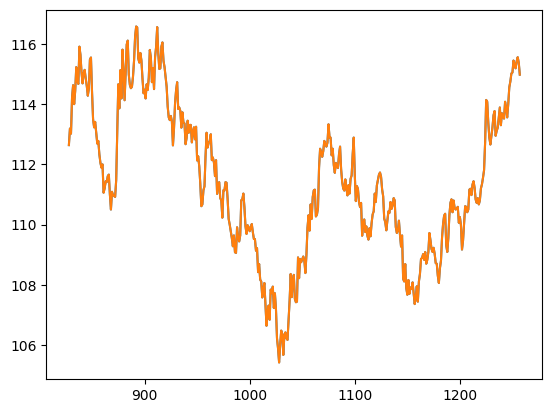

In [12]:
response = agent.invoke("2023年9月1日以降のCloseの値を時系列でラインチャートにしてください。")


In [13]:
print(response)

{'input': '2023年9月1日以降のCloseの値を時系列でラインチャートにしてください。', 'output': 'The final answer is the line chart of Close values on or after 2023-09-01. However, since the dataframe does not contain any dates on or after 2023-09-01, the chart will be empty.', 'intermediate_steps': [(AgentAction(tool='python_repl_ast', tool_input="df[df['Date'] >= '2023-09-01']['Close'].plot(kind='line')", log="Thought: I need to filter the dataframe to only include rows where the date is on or after 2023-09-01. Then I can plot the Close column.\nAction: python_repl_ast\nAction Input: df[df['Date'] >= '2023-09-01']['Close'].plot(kind='line')"), <Axes: >), (AgentAction(tool='python_repl_ast', tool_input="import matplotlib.pyplot as plt; df[df['Date'] >= '2023-09-01']['Close'].plot(kind='line'); plt.show()", log=" The plot is not showing because I am in a text-based environment. I need to add a command to display the plot.\nAction: python_repl_ast\nAction Input: import matplotlib.pyplot as plt; df[df['Date'] >= '2023-0

In [14]:
response['intermediate_steps'][0][0].tool_input.replace('; ', '\n')


"df[df['Date'] >= '2023-09-01']['Close'].plot(kind='line')"

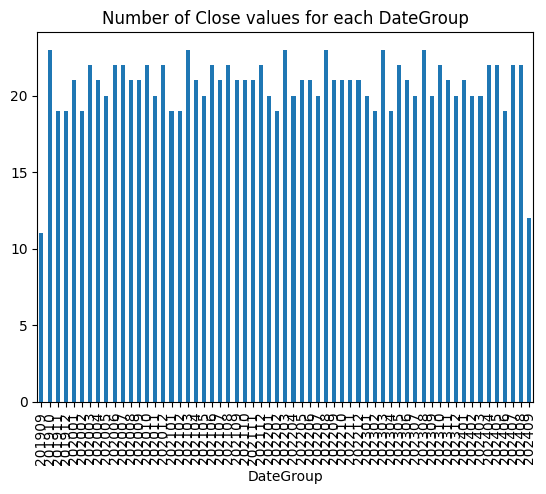

In [15]:
response = agent.invoke("DateGroupに含まれるCloseの日数をバーチャートにしてください。")


In [16]:
print(response['intermediate_steps'][0][0].tool_input.replace('; ', '\n'))

df.groupby('DateGroup')['Close'].count().plot(kind='bar')


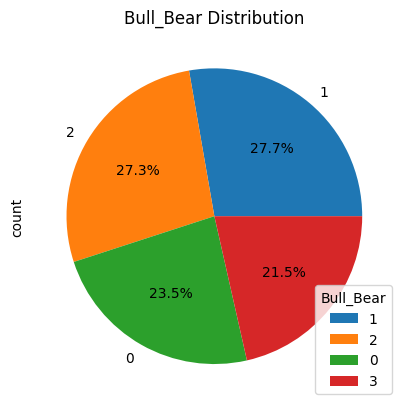

<Figure size 640x480 with 0 Axes>

In [17]:
response = agent.invoke("Bull_Bearに含まれる0から3の度数をパイチャートにして、欄外に次の脚注文章を加えてください。(3:Very Bull, 2:Weak Bull, 1:Weak Bear, 0:Very Bear)")


In [18]:
print(response['intermediate_steps'][0][0].tool_input.replace('; ', '\n'))


import matplotlib.pyplot as plt
import pandas as pd
df['Bull_Bear'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Bull_Bear Distribution')
plt.legend(title='Bull_Bear')
plt.show()


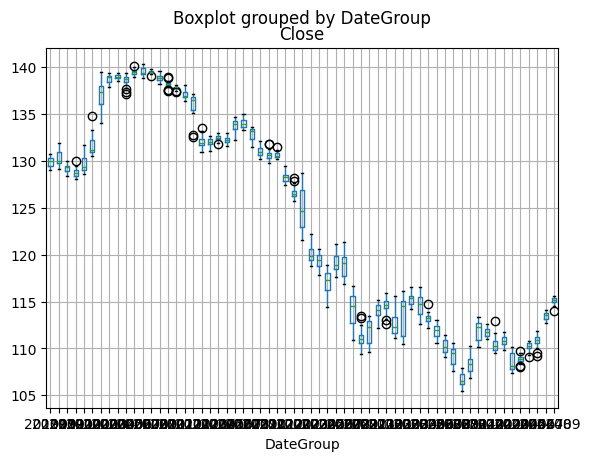

In [19]:
response = agent.invoke("DateGroupごとにCloseのボックスプロットを作成してください。")


In [20]:
print(response['intermediate_steps'][0][0].tool_input.replace('; ', '\n'))

df.boxplot(column='Close', by='DateGroup')


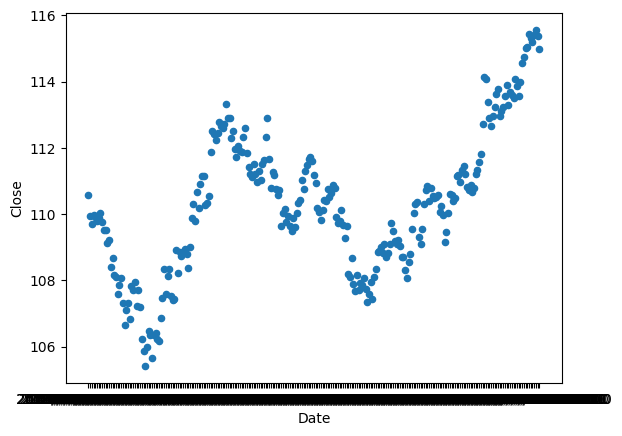

In [21]:
response = agent.invoke("DateGroupが2023年09月以降のデータについて、Closeのスキャッタープロットを作成してください。")


In [22]:
print(response['intermediate_steps'][0][0].tool_input.replace('; ', '\n'))


df[df['DateGroup'] >= 202309].plot.scatter(x='Date', y='Close')


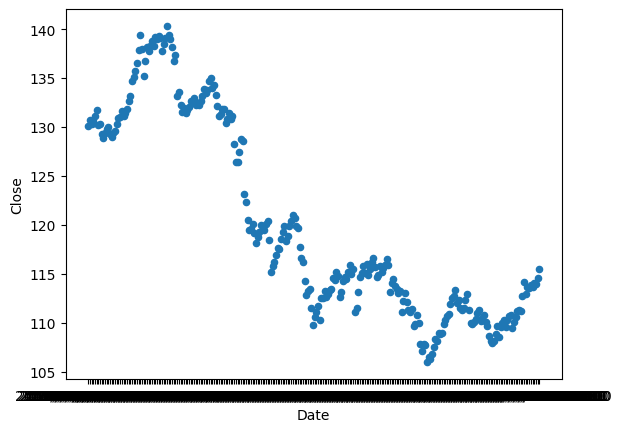

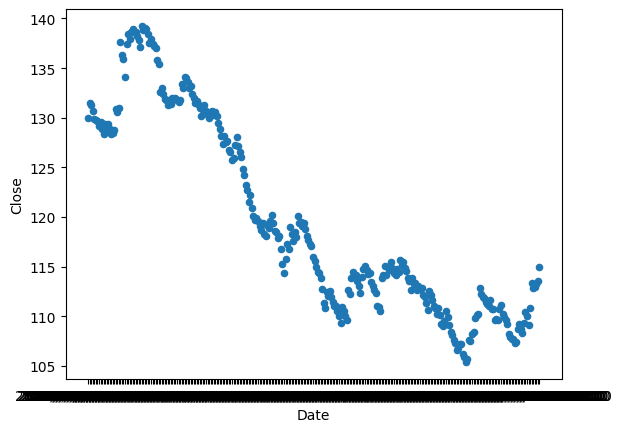

In [23]:
response = agent.invoke("Bull_Bearが3のデータを抜き出して、DateとCloseをスキャッタープロットにしてください。また、Bull_Bearが0のものを抜き出して、DateとCloseをスキャッタープロットにしてください。")


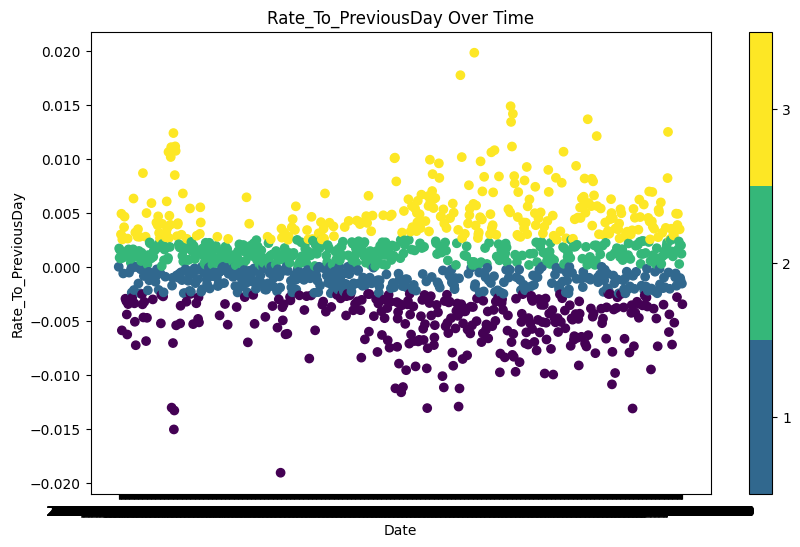

In [24]:
response = agent.invoke("Rate_To_PreviousDayの値をDate順に点でプロットしてください。Bull_Bearの値で赤・青・黄色・緑で色分けしてください。")


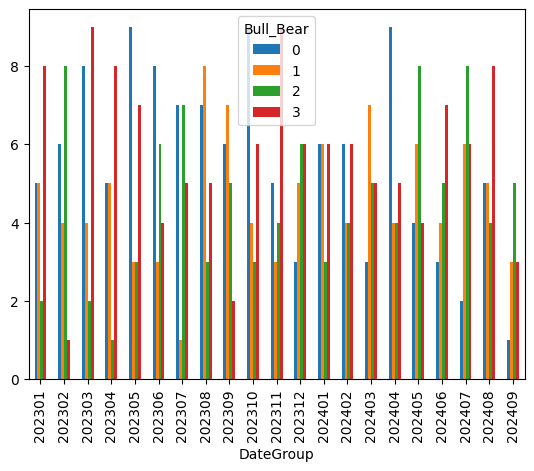

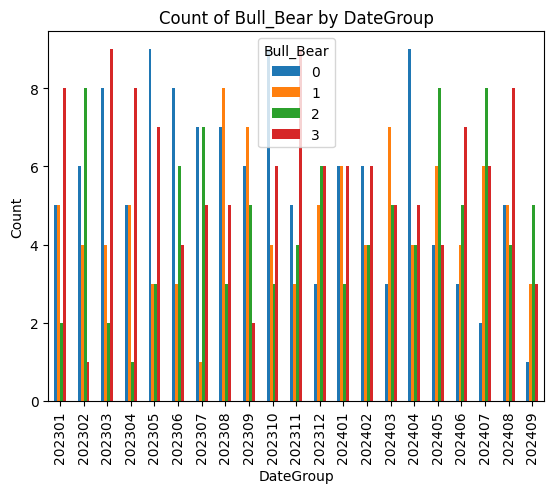

In [25]:
response = agent.invoke("2023年9月1日から現在までのデータについて、Bull_Bearの0から3のカウント数をDateGloupごとに棒グラフにして下さい。")


In [26]:
print("Fantastic FRB watcher(^^)b")

Fantastic FRB watcher(^^)b


## Author


Yuya MORI

## Thanks to


Coursera & IBM Skills Network

[Kang Wang](https://author.skills.network/instructors/kang_wang)

Kang Wang is a Data Scientist in IBM. He is also a PhD Candidate in the University of Waterloo.


[Wojciech Fulmyk](https://author.skills.network/instructors/wojciech_fulmyk) <br>
Wojciech "Victor" Fulmyk is a Data Scientist at IBM. He is also a PhD Candidate in Economics in the University of Calgary.
